# Raw images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget -O file_name.extension 'gdrive_link_here'

In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/top20_classified.zip'  # Path to the uploaded .zip file

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
# clean up folder structure i.e. remove 'plat_classif' folder in each class directory

import os
import shutil

# Path to the top-level folder
top_folder_path = '/content/top20_classified'

# Get a list of all class folders
class_folders = os.listdir(top_folder_path)

# Iterate over each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(top_folder_path, class_folder)

    # Check if the class folder contains 'plat_classif' folder
    if os.path.isdir(os.path.join(class_folder_path, 'plat_classif')):
        plat_classif_path = os.path.join(class_folder_path, 'plat_classif')

        # Get a list of files in 'plat_classif' folder
        files = os.listdir(plat_classif_path)

        # Move each file to the class folder
        for file in files:
            src = os.path.join(plat_classif_path, file)
            dst = os.path.join(class_folder_path, file)
            shutil.move(src, dst)

        # Remove the empty 'plat_classif' folder
        os.rmdir(plat_classif_path)

In [4]:
# how many images?
top20_folder = "/content/top20_classified"

image_count = 0

for root, dirs, files in os.walk(top20_folder):
    for file in files:
        file_ext = os.path.splitext(file)[1]
        if file_ext.lower() in [".jpg", ".jpeg", ".png", ".gif"]:
            image_count += 1

print(f"Number of images: {image_count}")

Number of images: 44357


In [6]:
# pick one image and check size in pixels
from PIL import Image

# Load image
image = Image.open("/content/top20_classified/Japanese/1002211.jpg")

# Get size of image
width, height = image.size

# Print size of image
print("Image size: {} x {}".format(width, height))

Image size: 1000 x 1000


### Find out corrupted by size
not the best method tho'

In [8]:
# find corrupted image (size less than 1kb)
import os

dataset_path = '/content/top20_classified'
max_size_kb = 5

# Iterate over each subdirectory
for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)

    # Check if the item in the directory is a subdirectory
    if os.path.isdir(subdir_path):
        # Get the list of image files in the subdirectory
        files = [file for file in os.listdir(subdir_path) if file.lower().endswith(('jpg', 'png', 'bmp', 'gif'))]

        # Iterate over each image file and print its size if it is less than 20 KB
        for file_name in files:
            file_path = os.path.join(subdir_path, file_name)
            size_kb = os.path.getsize(file_path) / 1024  # Size in kilobytes
            if size_kb < max_size_kb:
                print(f"Subdirectory: {subdir} - Image: {file_name} - Size: {size_kb:.2f} KB")

## Class distribution

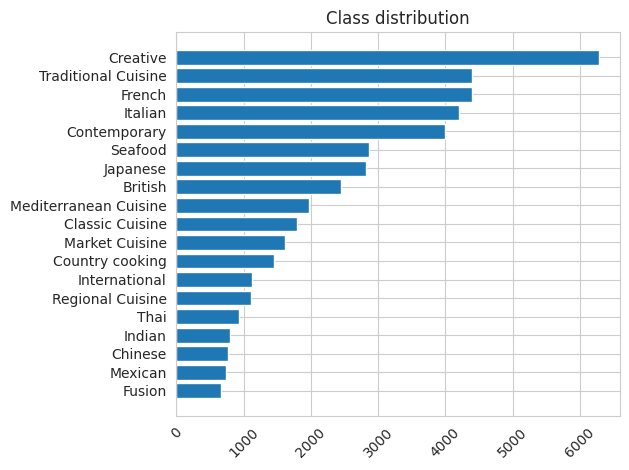

In [12]:
# check class distribution
import os
import matplotlib.pyplot as plt
import seaborn as sns

top20_folder = "/content/top20_classified"

folder_counts = {}

for folder_name in os.listdir(top20_folder):
    folder_path = os.path.join(top20_folder, folder_name)
    if os.path.isdir(folder_path):
        image_count = 0
        for filename in os.listdir(folder_path):
            file_ext = os.path.splitext(filename)[1]  # Get the file extension
            if file_ext.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
                image_count += 1
        folder_counts[folder_name] = image_count

# Extract folder names and counts for plotting
folders = list(folder_counts.keys())
counts = list(folder_counts.values())

sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=False)
folders = [folders[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Set the style to darkgrid
# sns.set_style("darkgrid")
sns.set_style("whitegrid")

# Plotting the bar chart
plt.barh(folders, counts)
# plt.ylabel("Image Count")
plt.title("Class distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Check what is 'guess top class' accuracy
top_index = folders.index("Creative")
top_count = counts[top_index]
total_images = sum(counts)

bestGuess = round(top_count / total_images, 2)
print("Best guess accuracy:", bestGuess)

Best guess accuracy: 0.14


# Test/train split

In [5]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your data input folder
data_folder = '/content/top20_classified'

# Define the batch size, image size, and validation split
batch_size = 16
image_size = (299, 299)
test_split = 0.2

# Load and preprocess train and test sets
input_train, input_test = keras.utils.image_dataset_from_directory(
    data_folder,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=test_split,
    subset='both',
    crop_to_aspect_ratio=True,
    seed=1
)

Found 44357 files belonging to 19 classes.
Using 35486 files for training.
Using 8871 files for validation.


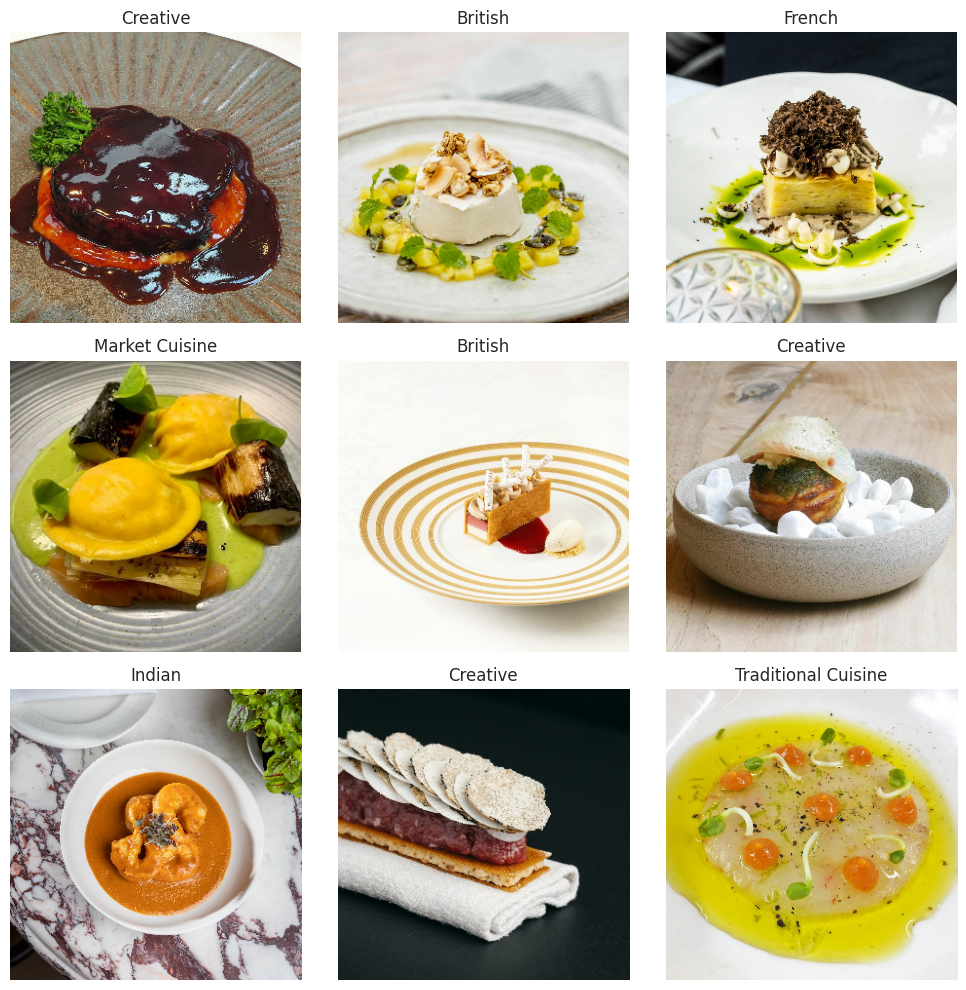

In [44]:
import matplotlib.pyplot as plt

# Show some from train set

# Get the class labels
class_names = input_train.class_names

# Create a 3x3 grid for displaying images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()  # Flatten the axes array for easier iteration

# Iterate over the dataset and display 9 images with labels
for images, labels in input_train.take(1):  # Take the first batch of images and labels
    for i in range(9):  # Display 9 images
        image = images[i]
        label = labels[i]
        class_label = class_names[np.argmax(label)]  # Convert TensorFlow tensor to NumPy array

        # Display the image in the corresponding subplot
        axes[i].imshow(image.numpy().astype('uint8'))
        axes[i].set_title(class_label)
        axes[i].axis('off')

# Adjust spacing and display the grid
plt.tight_layout()
plt.show()

# Image augmentation

In [6]:
# Define image augmentation
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
    ]
)

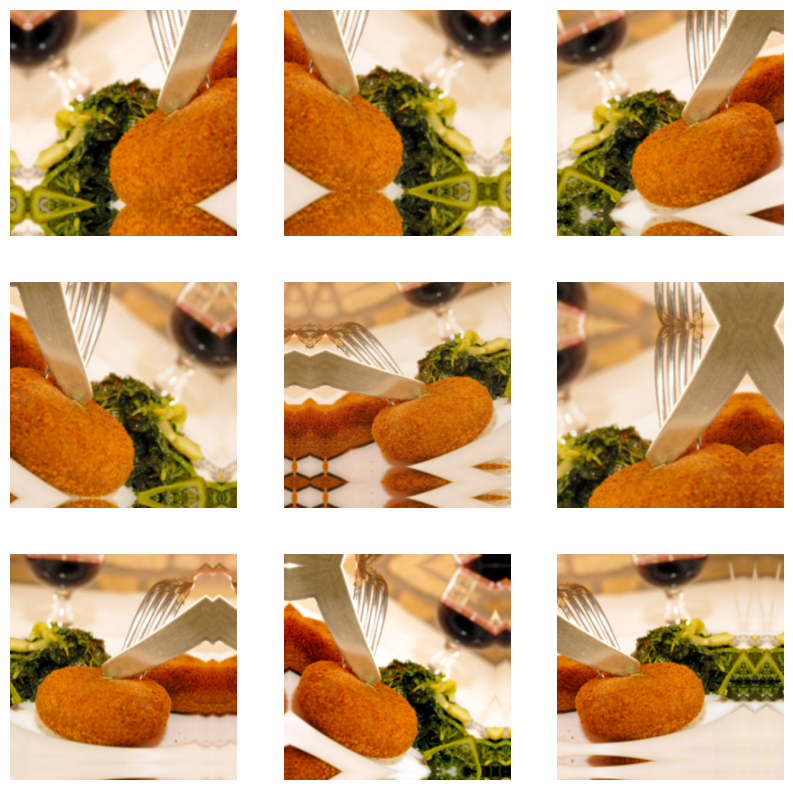

In [8]:
import matplotlib.pyplot as plt

# Show some image augmentation
plt.figure(figsize=(10, 10))
for images, _ in input_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
# Apply image augmentation

augmented_input_train = input_train.map(
    lambda x, y: (data_augmentation(x, training=True), y))

# Modelis

In [10]:
# import tensorflow.keras as keras: DEPRECATED
from tensorflow import keras

# Base model
base_model = keras.applications.Xception(
    weights='imagenet',  # Pre-trained weights from ImageNet
    input_shape=(299, 299, 3),
    include_top=False)  # Discards top layer of ImageNet Classifier

# Freeze model, so that weights remain the same even after training on new data
base_model.trainable = False

# Create a new model on top of the base model
inputs = keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)  # Adding dropout regularization
predictions = keras.layers.Dense(19, activation='softmax')(x)
model = keras.Model(inputs, outputs=predictions)

# Compile the model with appropriate loss and metrics for multi-class classification
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

83683744/83683744 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 19)                4883      
                                                             

## Training

In [12]:
# Train the model (EfficientNetB0)
epochs = 3
fit = model.fit(augmented_input_train, epochs=epochs, validation_data=input_test)

Epoch 1/3
2218/2218 [==============================] - 1437s 641ms/step - loss: 3.2580 - categorical_accuracy: 0.1387 - val_loss: 2.7513 - val_categorical_accuracy: 0.1409
Epoch 2/3
2218/2218 [==============================] - 1431s 644ms/step - loss: 2.7285 - categorical_accuracy: 0.1414 - val_loss: 2.7352 - val_categorical_accuracy: 0.1411
Epoch 3/3
2218/2218 [==============================] - 1422s 641ms/step - loss: 2.7290 - categorical_accuracy: 0.1417 - val_loss: 2.7351 - val_categorical_accuracy: 0.1411


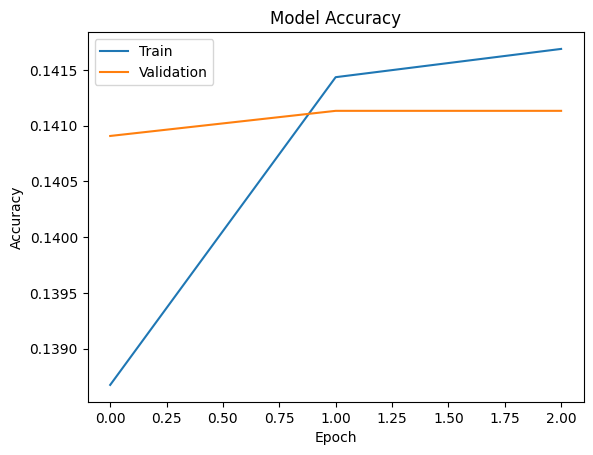

In [13]:
# Access the training history
history = fit.history

# Plot accuracy
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(False)
plt.show()

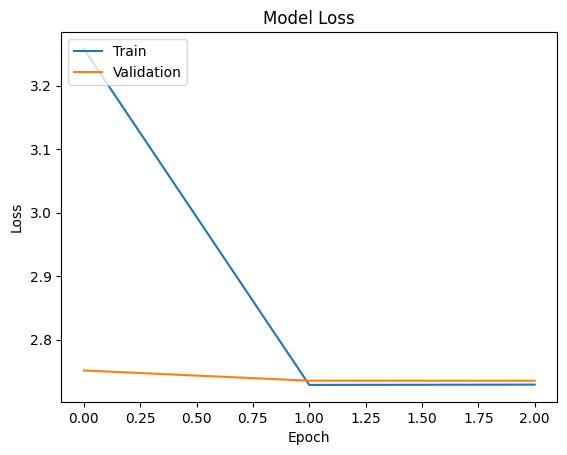

In [14]:
# Access the training history
history = fit.history

# Plot loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(False)
plt.show()

In [ ]:
# # Get the predictions for the test set
# preds = model.predict(input_test)

## Plot some predictions together with images

`np.argmax()` to find the index of the predicted label with highest probability

### Top-1 probability

1/1 [==============================] - 0s 24ms/step


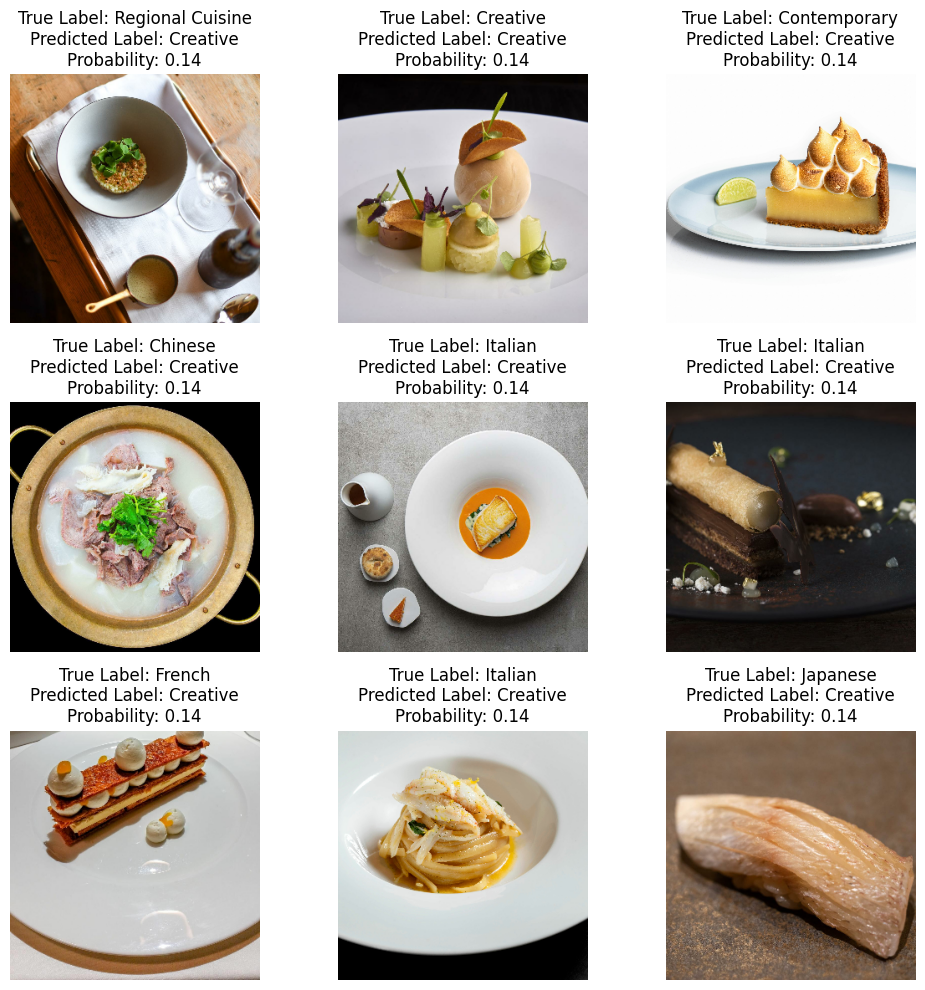

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class labels
class_names = input_test.class_names

# Select 9 random indices from the test set
random_indices = np.random.choice(len(input_test), 9, replace=False)

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the random indices and display images with labels, predictions, and probabilities
for i, index in enumerate(random_indices):
    # Get the image and true label
    image_batch = next(iter(input_test.unbatch().skip(index).take(1)))
    image = image_batch[0]
    true_label = class_names[np.argmax(image_batch[1])]

    # Calculate the subplot index
    row = i // 3
    col = i % 3

    # Display the image in the corresponding subplot
    axes[row, col].imshow(image.numpy().astype('uint8'))
    axes[row, col].axis('off')

    # Predict the label and probability for the selected image
    predictions = model.predict(np.expand_dims(image, axis=0))
    predicted_label = class_names[np.argmax(predictions)]
    probability = predictions[0][np.argmax(predictions)]

    # Add labels and probabilities to the subplot title
    title = f'True Label: {true_label}\nPredicted Label: {predicted_label}\nProbability: {probability:.2f}'
    axes[row, col].set_title(title)

plt.tight_layout()
plt.show()

### Top-3 probability

1/1 [==============================] - 0s 30ms/step


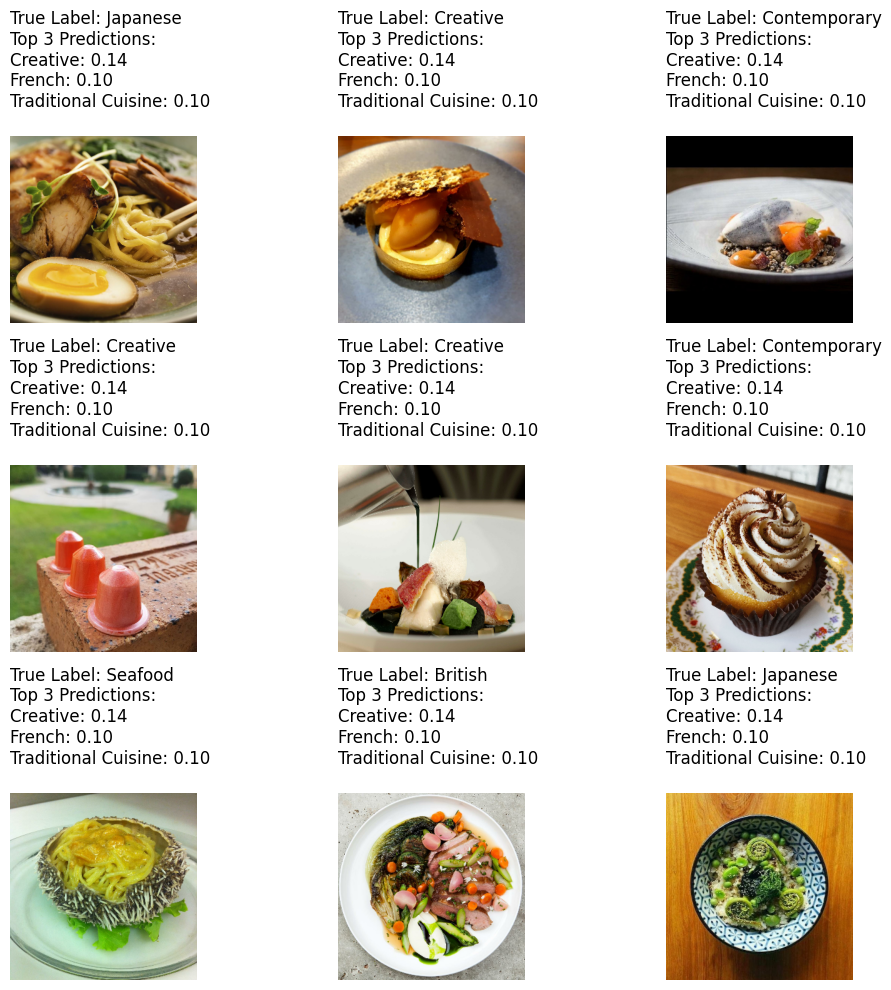

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class labels
class_names = input_test.class_names

# Select 9 random indices from the test set
random_indices = np.random.choice(len(input_test), 9, replace=False)

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the random indices and display images with labels, predictions, and probabilities
for i, index in enumerate(random_indices):
    # Get the image and true label
    image_batch = next(iter(input_test.unbatch().skip(index).take(1)))
    image = image_batch[0]
    true_label = class_names[np.argmax(image_batch[1])]

    # Calculate the subplot index
    row = i // 3
    col = i % 3

    # Display the image in the corresponding subplot
    axes[row, col].imshow(image.numpy().astype('uint8'))
    axes[row, col].axis('off')

    # Predict the label and probabilities for the selected image
    predictions = model.predict(np.expand_dims(image, axis=0))
    top_indices = np.argsort(predictions[0])[::-1][:3]  # Get indices of top 3 probabilities
    top_labels = [class_names[i] for i in top_indices]  # Get labels corresponding to top indices
    top_probabilities = predictions[0][top_indices]  # Get top probabilities

    # Add true label, top labels, and probabilities to the subplot title
    title = f'True Label: {true_label}\nTop 3 Predictions:\n'
    for label, probability in zip(top_labels, top_probabilities):
        title += f'{label}: {probability:.2f}\n'
    axes[row, col].set_title(title, loc='left')

plt.tight_layout()
plt.show()

## Check accuracy for each class

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the class labels
class_names = input_test.class_names

# Predict labels for the test set
predictions = model.predict(input_test)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels for the test set
true_labels = np.concatenate([y for x, y in input_test], axis=0)
true_labels = np.argmax(true_labels, axis=1)

555/555 [==============================] - 106s 188ms/step


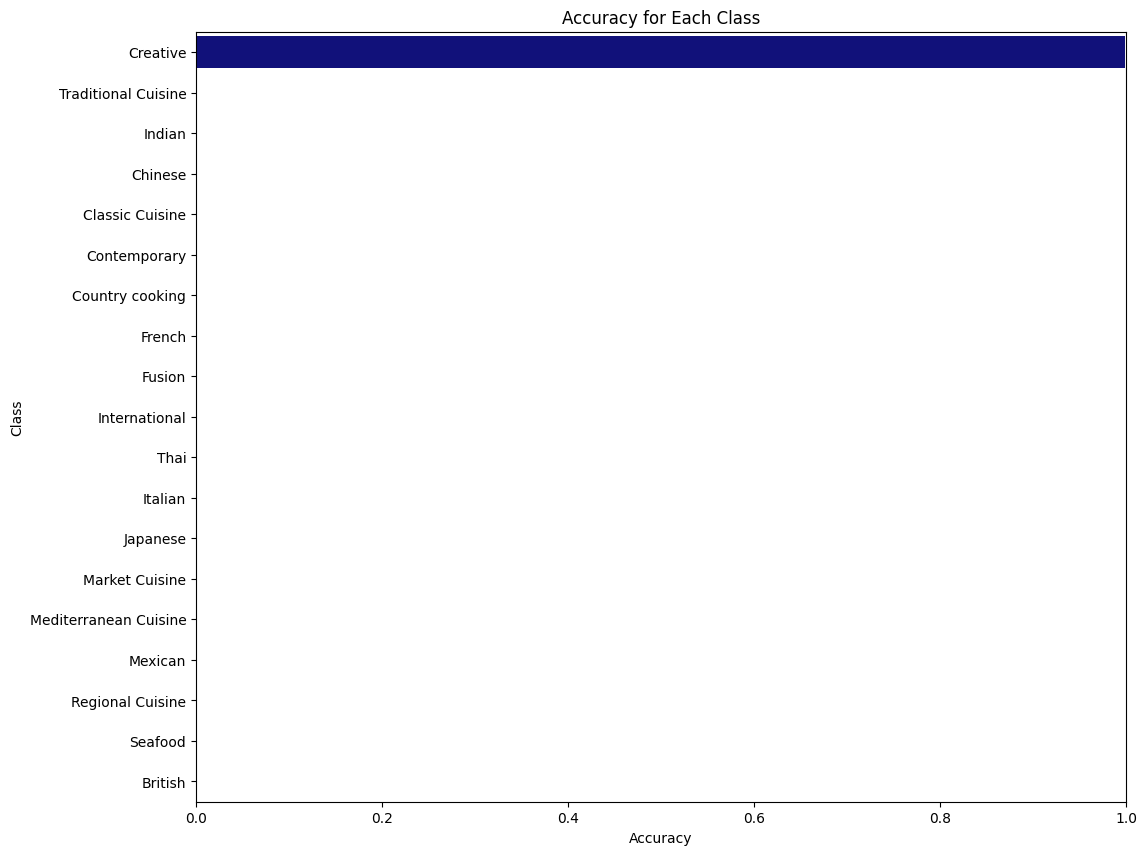

In [19]:
# Calculate accuracy for each class
accuracies = []
for class_index in range(len(class_names)):
    true_mask = (true_labels == class_index)
    predicted_mask = (predicted_labels == class_index)
    class_accuracy = np.mean(true_labels[true_mask] == predicted_labels[true_mask])
    accuracies.append(class_accuracy)

# Sort class names and accuracies based on accuracies
sorted_indices = np.argsort(accuracies)[::-1]
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Plot accuracy for each class (sorted horizontal bar chart)
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_accuracies, y=sorted_class_names, color='darkblue')
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Accuracy for Each Class')
plt.xlim(0, 1)
plt.show()

## Confusion matrix

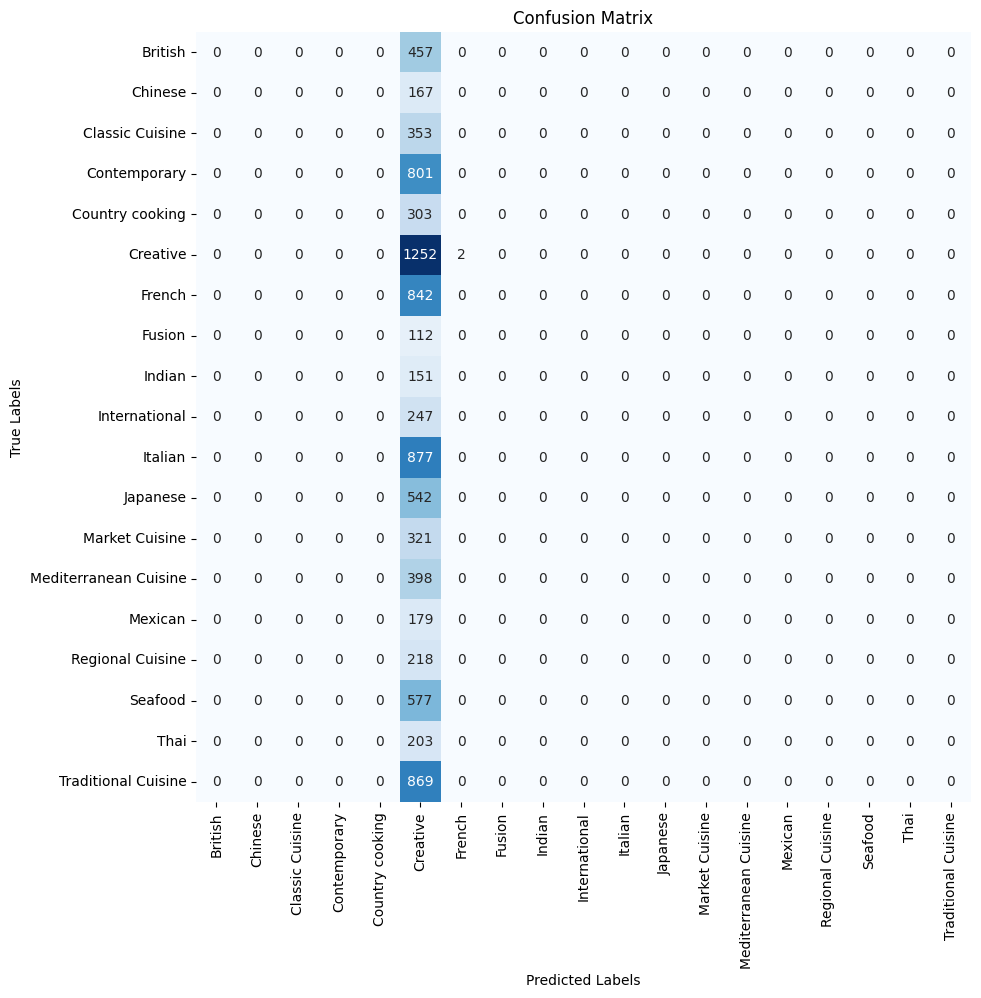

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()